
# Подготовка данных с Кэгла



In [ ]:
!python3 --version

Python 3.7.10


In [ ]:
# '_ih' - выдает историю всех ячеек

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip3 install pymorphy2
!pip3 install shap
!pip3 install lime

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=083005068cea17dfeb703df334edf305b745a57c94f32ca6e02c48cb9827af02
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 8.2MB 8.9MB/s 
     |████████████████████████████████| 358kB 6.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=9ef29932925ac1a9c155b603ec7b65798ad71fafc5761fb409ec990b80aa2366
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 276kB 9.4MB/s 
  Created wheel for lime: file

In [ ]:
# Colab library to upload files to notebook
from google.colab import files

#Install Kaggle library
!pip3 install -q kaggle


import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import pymorphy2
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import xgboost
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, cross_val_score

import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import rpy2.ipython
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%reload_ext rpy2.ipython

from sklearn import decomposition, ensemble
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3
from scipy.sparse import hstack
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c asap-sas

 38% 9.00M/24.0M [00:00<00:00, 24.1MB/s]
100% 24.0M/24.0M [00:00<00:00, 53.9MB/s]


In [ ]:
!ls

asap-sas.zip  kaggle.json  sample_data


In [ ]:
! unzip asap-sas.zip 

Archive:  asap-sas.zip
  inflating: Data_Set_Descriptions.zip  
  inflating: Guidelines for Transcribing Student Essays.docx  
  inflating: Training_Materials.zip  
  inflating: bag_of_words_benchmark.csv  
  inflating: length_benchmark.csv    
  inflating: private_leaderboard.tsv  
  inflating: public_leaderboard.tsv  
  inflating: public_leaderboard_rel_2.tsv  
  inflating: public_leaderboard_solution.csv  
  inflating: test.csv                
  inflating: train.tsv               
  inflating: train_rel_2.tsv         


In [ ]:
data = pd.read_table('train.tsv',sep='\t')

In [ ]:
data = data.drop(columns=["Id",'Score1'])
y = data["Score2"]
X = data.drop(columns=["Score2"])

In [ ]:
data[(data['EssaySet'] == 8) & (data['Score2'] == 1)]

EssaySet  Score2                                          EssayText
11971         8       1  The background information about Mr. Leonard r...
11972         8       1  It motivated him, He knew what Mr. leonard mea...
11974         8       1  The information has an effect on Paul because ...
11978         8       1   He relates to Mr. Leonard. So feels bad for him.
11987         8       1  The effect the backround information has on Pa...
...         ...     ...                                                ...
13753         8       1  When Paul get the background information fro m...
13761         8       1  The effect that the backgroung information had...
13762         8       1  The backround information about Mr. Leonard is...
13763         8       1  He wants to help Mr. Leonard because Mr. Leona...
13767         8       1  The backround information makes Mr. leonard an...

[466 rows x 3 columns]

In [ ]:
data['EssayText'][11971]

'The background information about Mr. Leonard relates to paul because they both couldnt read very good and mr. Leonard wants paul to to do better in life then what he did. it effects paul by making him want to try hard in track and school.'

# Предобработка данных

## Лемматизация или стемминг?
Начнем с того, что разница подходов в том, что стемминг более груб и удаляет окончания, а лемматизация приводит токен в начальную лемму.
Кажется подход очень зависит от выбранного языка, например, русский -  флективный язык (простыми словами, куча новых форм слов образуются засчет приставок, суфиксов и окончаний, которые меняют род, падеж и тд). \\
Английский - флективно-изолирующий (если кратко, отсутствует или слаборазвито словообразование: I read — He reads; высокая значимость порядка слов)


Они также отличаются тем, что стемминг чаще всего разрушает слова, которые являются производными одной и той же леммы, тогда как лемматизация обычно разрушает только различные флективные формы леммы.

Пример: \\
стемминг different --> differ \\
лемматизация different --> different

Нам необходимо по ответу ученика выставить оценку, возникает вопрос - нам важнее оставить лемму слова или же стемм для модели? (не поняла пока насколько важный вектор рассуждений...)

In [ ]:
ps = nltk.stem.PorterStemmer()
sno = nltk.stem.SnowballStemmer('english')
morph = pymorphy2.MorphAnalyzer()
lemma = nltk.wordnet.WordNetLemmatizer()

def prepare_data(text=None):
    text = re.sub(r'[\s\n]',' ', text)
    text = re.sub(r'[\\.!?-@#%&*",:`~)(}{|_–;…«»]','', text)
    #text = re.sub(r'\s{2,}',' ', text) # удалим все лишние пробелы
    text = text.split(' ')
    for i in range(len(text)):
      #text[i] = ps.stem(text[i]) # сделаем лемматизацию
      text[i] = morph.parse(text[i])[0].normal_form
    STOP = set(stopwords.words())
    text = [word for word in text if not word in STOP] # уберем стоп слова
    return ' '.join(text)

In [ ]:
texts = X['EssayText']

for i in tqdm(range(len(texts))):
  texts[i] = prepare_data(texts[i])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Посмотрим на множество оценок, которые выставляются ученикам:

In [ ]:
 y.unique()

array([1, 0, 2, 3])

## Векторизация

In [ ]:
vectorizer = TfidfVectorizer(encoding='utf8', max_features=5000)
vectorizer.fit(texts)

df = vectorizer.transform(texts)

In [ ]:
df.shape

(17207, 17375)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

# Обучаем базовые модели

## Логистическая регрессия

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict_proba(X_test)
print(roc_auc_score(y_test, preds, multi_class='ovo'))
                            

0.8704229888800651


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Важность признаков


In [ ]:
f_weights = zip(vectorizer.get_feature_names(), lr.coef_[0])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])
    
print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

## Решающие деревья

In [ ]:
cv = KFold(shuffle=True, random_state=241)

# clf = DecisionTreeClassifier(criterion = "gini", random_state = 42,
#                                max_depth=10, min_samples_leaf=1000)


gs = GridSearchCV(DecisionTreeClassifier(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2', 'sqrt'],
                      'max_depth': [2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90],
                      'min_samples_leaf': [1, 4, 8, 32, 40, 50, 100, 300],
                  },
                  cv=cv,
                  scoring='roc_auc_ovo',
                  verbose=2)
gs.fit(df, y)

cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']

cv_grid = cv_grid.sort_values(by=['mean_test_score'], ignore_index=True, ascending=False)

cv_grid.head()

In [ ]:
gs.best_score_

0.7859457324179109

In [ ]:
gs.best_params_

{'max_depth': 90, 'max_features': 'auto', 'min_samples_leaf': 8}

In [ ]:
clf = DecisionTreeClassifier(criterion = "gini", random_state = 42,
                             max_depth=10, min_samples_leaf=8)
clf.fit(X_train, y_train)

preds_clf = clf.predict_proba(X_test)
print(roc_auc_score(y_test, preds_clf, multi_class='ovo'))

0.7737193748204249


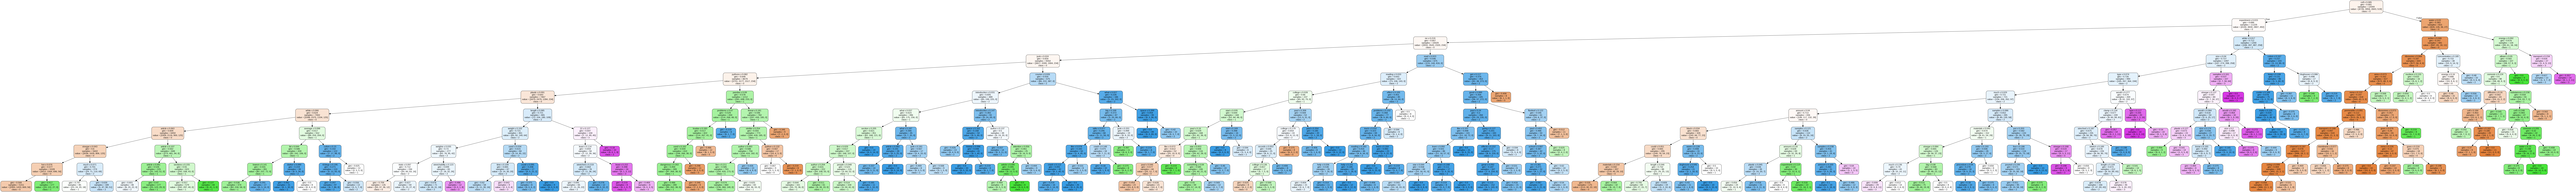

In [ ]:
import io
from io import StringIO
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = vectorizer.get_feature_names(),class_names=['0','1','2', '3'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
# feature_cols = vectorizer.get_feature_names()
# dot_data = export_graphviz(clf,
#                                 feature_names=feature_cols,
#                                 out_file=None,
#                                 filled=True,
#                                 rounded=True)

# pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('original_tree.png')
# pydot_graph.set_size('"10,5!"')
# pydot_graph.write_png('resized_tree.png')

# import graphviz
# gvz_graph = graphviz.Source(pydot_graph.to_string())
# gvz_graph

In [ ]:
feature_cols = vectorizer.get_feature_names()
clf.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, clf.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(10)

FeatureImportance
cell                 0.086894
junk                 0.080322
mr                   0.072877
experiment           0.071451
white                0.060762
pythons              0.055098
article              0.053506
vinegar              0.047542
plastic              0.047326
hot                  0.034435

# Обучаем xgboost на tf-idf векторах данных и пробуем интерпретацию методом LIME

In [ ]:
# dtest = xgb.DMatrix(X_test)

# x_train, x_valid, Y_train, Y_valid = train_test_split(
#         X_train, y_train, test_size=0.2, random_state=100)

# d_train = xgb.DMatrix(X_train, label=y_train)

# xgb_params = {'eta': 0.3, 
#           'max_depth': 9, 
#           'subsample': 0.8, 
#           'colsample_bytree': 0.8, 
#           'multi': 'softprob', 
#           'eval_metric': 'mlogloss', 
#           'seed': 0,
#           'num_class': 4
#           }
# d_valid = xgb.DMatrix(x_valid, Y_valid)
# watchlist = [(d_valid, 'valid')]

#num_round = 100
#bst = xgb_clf.train(xgb_params, d_train, num_round, watchlist)

# ypred_np = ypred.astype('int64')
# y_test_np = y_test.to_numpy()

# from sklearn import metrics
# metrics.f1_score(y_test_np, ypred_np, average='weighted')

In [ ]:
# clf = xgb.XGBClassifier()
# parameters = {
#      "eta"    : [0.1, 0.3 ] ,
#      "max_depth"        : [3, 5],
#      "min_child_weight" : [ 1, 5],
#      "gamma"            : [ 0.0, 0.2]
#      }

# grid = GridSearchCV(clf,
#                     parameters,
#                     scoring="neg_log_loss",
#                     cv=3,
#                     verbose=2)

# grid.fit(X_train, y_train)

# cv_grid = pd.DataFrame(grid.cv_results_['params'])

# cv_grid['mean_test_score'] = grid.cv_results_['mean_test_score']

# cv_grid = cv_grid.sort_values(by=['mean_test_score'], ignore_index=True, ascending=False)

# cv_grid.head()

In [ ]:
# grid.best_score_

In [ ]:
# grid.best_params_

In [ ]:
clf = xgb.XGBClassifier(max_depth=5, learning_rate=0.05, gamma=0.6, n_estimators=1000, objective='multi:softprob')

x_train, x_valid, Y_train, Y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=100)

eval_set = [(x_valid, Y_valid)]

clf.fit(x_train, Y_train, eval_metric="mlogloss", eval_set=eval_set, verbose=True)

In [ ]:
ypred = clf.predict_proba(X_test)
print(roc_auc_score(y_test, ypred, multi_class='ovo'))

In [ ]:
class_names = ['0', '1', '2', '3']

c = make_pipeline(vectorizer, clf)
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
print(c.predict_proba([texts[1234]]).round(3))

[[0.063 0.473 0.446 0.018]]


In [ ]:
texts[4321]

In [ ]:
idx = 4872
exp = explainer.explain_instance(texts[idx], c.predict_proba, num_features=4, top_labels=4)
print(exp.available_labels())

[1, 2, 0, 3]


In [ ]:
exp.show_in_notebook(text=X['EssayText'][idx])

In [ ]:
exp.show_in_notebook(text=X['EssayText'][idx], labels=(3,))

##SHAP

In [ ]:
explainer = shap.LinearExplainer(lr,
                                 X_train,
                                 feature_dependence="independent")

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [ ]:
shap_values = explainer.shap_values(X_test)

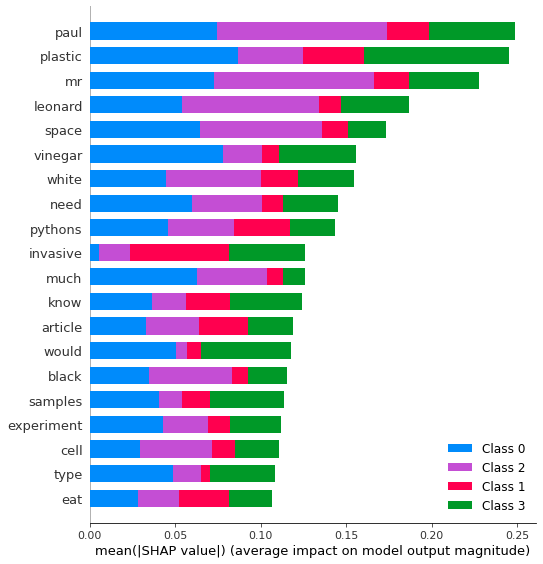

In [ ]:
X_test_array = X_test.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=vectorizer.get_feature_names())

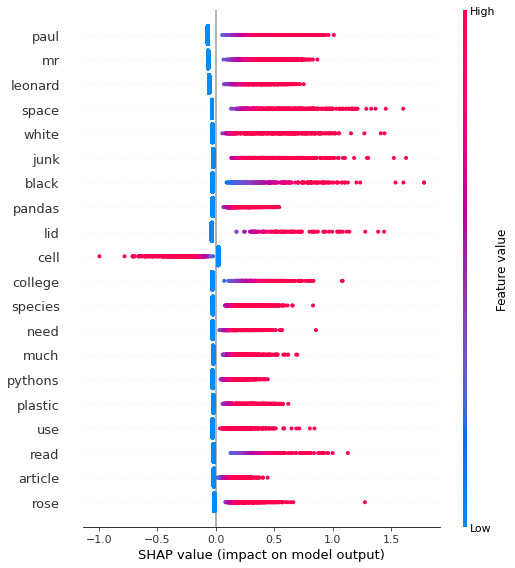

In [ ]:
shap.summary_plot(shap_values[2],
                  X_test_array,
                  feature_names=vectorizer.get_feature_names(),
                  plot_type='dot')

In [ ]:
shap.force_plot(explainer.expected_value[0],
                shap_values[0],
                X.iloc[0,:],
                feature_names=vectorizer.get_feature_names())

In [ ]:
!pip3 install tensorflow==2.1

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import shap